# Imports

In [20]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [21]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# sanity check
project_config["TKL"]

'ATCMF'

# Download TKL data from YF

In [23]:
from datetime import date, timedelta
end_date = date.today() - timedelta(days=1)
start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"]))

In [24]:
tickers_yf = {
    "y"           : f"{project_config['TKL']}",
    "NASDAQ"      : "^IXIC",
    "SP500"       : "^GSPC",
    "RealEstate"  : "VNQ",
    "Oil_WTI"     : "CL=F",
    "Gold": "GC=F"
}

tickers_fred = {
 #   "Inflation_CPI" : "CPIAUCSL",
 #   "Unemployment"  : "UNRATE"
}

In [25]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

# ---- DOWNLOAD FROM YAHOO FINANCE ----
ts_yf = yf.download(
    tickers=list(tickers_yf.values()),
    start=start_date,
    end=end_date,
    auto_adjust=True
)["Close"]

# rename columns to readable names
ts_yf.columns = list(tickers_yf.keys())

# ---- DOWNLOAD FROM FRED ----
ts_fred = pd.DataFrame()
for name, fred_code in tickers_fred.items():
    ts_fred[name] = pdr.DataReader(fred_code, "fred", start_date, end_date)


# ---- MERGE ALL ----
ts = pd.concat([ts_yf, ts_fred], axis=1)

# Fill missing daily values for macro data (monthly)
ts = ts.ffill()  # forward fill
ts = ts.dropna()  # drop any remaining rows

ts = ts.reset_index().rename(columns={"Date": "Date"})

display(ts.head(1))
display(ts.tail(1))

[*********************100%***********************]  6 of 6 completed


,Date,y,NASDAQ,SP500,RealEstate,Oil_WTI,Gold
0,2013-03-18,0.945,93.739998,1604.599976,42.136612,1552.099976,3237.590088


,Date,y,NASDAQ,SP500,RealEstate,Oil_WTI,Gold
3202,2025-12-04,0.159,59.669998,4211.799805,89.980003,6857.120117,23505.140625


# Turn time series into supprvied learning table

In [26]:
lags = [1,5,10,22,65] # lookback days
windows =  [5,10,22,65] # statistics windows

df = ts.copy()

# Identify columns to generate features for (excluding 'Date')
feature_base_cols = [c for c in df.columns if c not in ['Date']]

for base_col in feature_base_cols: # Iterate over TKL cols

  # Generate lagged features for the current base_col
  for lag in lags:
    df[f"{base_col}_lag_{lag}"] = df[base_col].shift(lag)

  # Generate rolling window statistics for the current base_col
  for window in windows:
    df[f"{base_col}_min_{window}"] = df[base_col].rolling(window=window).min()
    df[f"{base_col}_max_{window}"] = df[base_col].rolling(window=window).max()
    df[f"{base_col}_mean_{window}"] = df[base_col].rolling(window=window).mean()
    df[f"{base_col}_std_{window}"]  = df[base_col].rolling(window=window).std()
    df[f"{base_col}_diff_{window}"] = df[base_col].diff(window)
    df[f"{base_col}_pct_{window}"] = df[base_col].pct_change(window)


df['y_next'] = df['y'].shift(-1)    # tomorrow's price
df.tail(1)['y_next'] = -1           # the target cell

df.dropna(inplace=True)

# Drop 'Date' column from X, along with 'y' and 'y_next'
X = df.drop(['Date', 'y','y_next'], axis=1)
y = df['y_next']

In [27]:
X_train, X_test = X.iloc[:-2], X.iloc[-1:]
y_train, y_test = y.iloc[:-2], y.iloc[-1:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3135, 179), (1, 179), (3135,), (1,))

# Train, Predict, Evaluate

In [28]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [29]:
pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

MAE: 0.005056649446487427


In [30]:
last_row = X_test # Use X_test which was successfully predicted upon
tomorrow_prediction = xgb.predict(last_row)[0]
tomorrow_prediction

np.float32(0.16405664)

# Feature selection

<Figure size 1000x600 with 0 Axes>

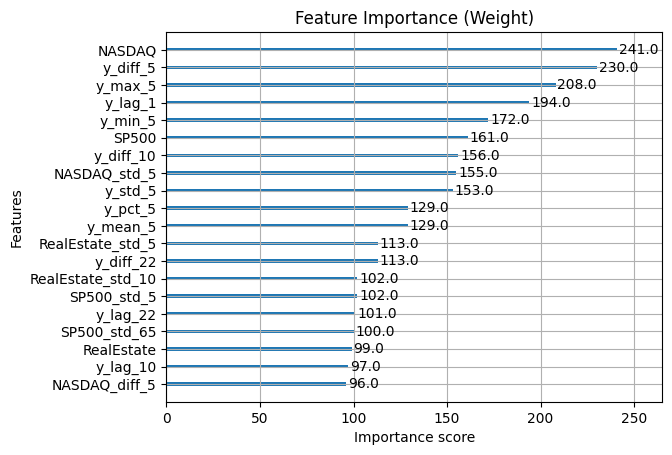

['NASDAQ', 'y_diff_5', 'y_max_5', 'y_lag_1', 'y_min_5', 'SP500', 'y_diff_10', 'NASDAQ_std_5', 'y_std_5', 'y_mean_5', 'y_pct_5', 'y_diff_22', 'RealEstate_std_5', 'SP500_std_5', 'RealEstate_std_10']


In [31]:
import matplotlib.pyplot as plt
import xgboost # Import the xgboost module

# Plot feature importance based on "weight" (number of times a feature appears in a tree)
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Weight)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='weight')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_weight_features_list = df_importance['Feature'].head(15).tolist()
print(top_weight_features_list)

<Figure size 1000x600 with 0 Axes>

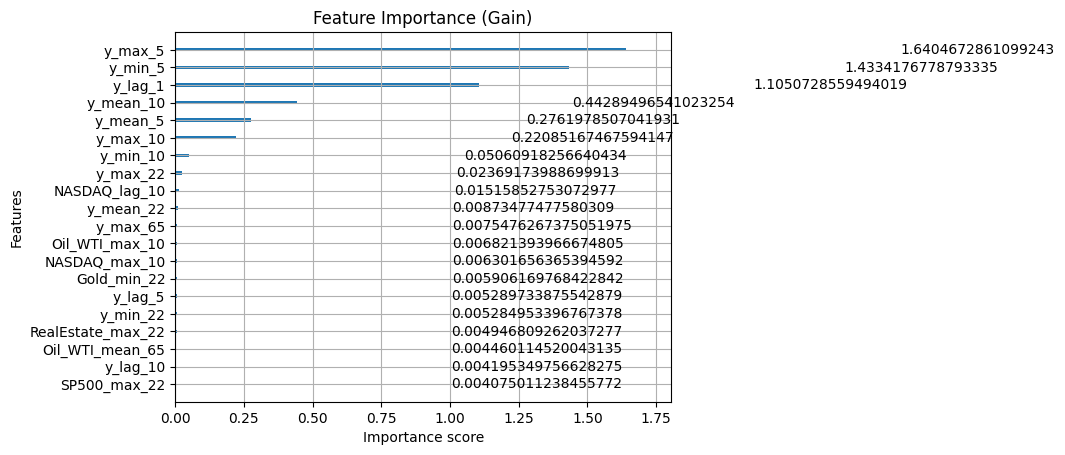

['y_max_5', 'y_min_5', 'y_lag_1', 'y_mean_10', 'y_mean_5', 'y_max_10', 'y_min_10', 'y_max_22', 'NASDAQ_lag_10', 'y_mean_22', 'y_max_65', 'Oil_WTI_max_10', 'NASDAQ_max_10', 'Gold_min_22', 'y_lag_5']


In [32]:
# OPTIONAL: Plot based on "gain" (average gain of splits which use the feature)
# "Gain" is often more accurate for finding what actually drives the prediction.
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Gain)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='gain')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_gain_features_list = df_importance['Feature'].head(15).tolist()
print(top_gain_features_list)

In [33]:
top_features = list(set(top_gain_features_list) | set(top_weight_features_list))
top_features

['y_diff_10',
 'y_max_10',
 'Gold_min_22',
 'y_pct_5',
 'SP500_std_5',
 'y_diff_5',
 'y_std_5',
 'y_mean_10',
 'y_max_22',
 'y_max_5',
 'NASDAQ_std_5',
 'NASDAQ_lag_10',
 'SP500',
 'y_min_10',
 'y_min_5',
 'y_lag_5',
 'NASDAQ',
 'y_mean_5',
 'y_lag_1',
 'y_mean_22',
 'RealEstate_std_5',
 'RealEstate_std_10',
 'Oil_WTI_max_10',
 'y_diff_22',
 'NASDAQ_max_10',
 'y_max_65']

# Final df

In [34]:
final_df = df[['Date','y_next','y'] + top_features]
final_df

,Date,y_next,y,y_diff_10,y_max_10,Gold_min_22,y_pct_5,SP500_std_5,y_diff_5,y_std_5,...,NASDAQ,y_mean_5,y_lag_1,y_mean_22,RealEstate_std_5,RealEstate_std_10,Oil_WTI_max_10,y_diff_22,NASDAQ_max_10,y_max_65
65,2013-06-19,0.484,0.555,-0.078,0.633,3400.429932,0.023985,8.033215,0.013,0.007120,...,98.239998,0.5498,0.555,0.613091,0.504146,0.569207,1651.810059,-0.053,98.440002,0.971
66,2013-06-20,0.484,0.484,-0.149,0.633,3364.639893,-0.107011,41.777902,-0.058,0.030817,...,95.400002,0.5382,0.555,0.607455,1.256901,0.944242,1651.810059,-0.124,98.440002,0.971
67,2013-06-21,0.484,0.484,-0.149,0.633,3357.250000,-0.107011,47.269655,-0.058,0.038888,...,93.690002,0.5266,0.484,0.600864,1.349014,1.026464,1651.810059,-0.145,98.440002,0.971
68,2013-06-24,0.484,0.484,-0.149,0.592,3320.760010,-0.127928,47.101143,-0.071,0.038888,...,95.180000,0.5124,0.484,0.594545,1.249025,1.105341,1651.810059,-0.139,98.440002,0.971
69,2013-06-25,0.484,0.484,-0.108,0.555,3320.760010,-0.127928,41.406954,-0.071,0.031752,...,95.320000,0.4982,0.484,0.588136,0.669631,1.119383,1651.810059,-0.141,98.440002,0.971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3197,2025-11-26,0.150,0.150,-0.005,0.155,22078.050781,0.034483,45.040043,0.005,0.005404,...,58.650002,0.1438,0.144,0.141500,1.122921,0.889497,6812.609863,0.004,60.740002,0.203
3198,2025-11-28,0.164,0.150,-0.005,0.150,22078.050781,0.071429,57.166263,0.010,0.005495,...,58.549999,0.1458,0.150,0.141818,0.767431,1.065269,6849.089844,0.007,60.740002,0.203
3199,2025-12-01,0.158,0.164,0.014,0.164,22078.050781,0.197080,59.589394,0.027,0.007563,...,59.320000,0.1512,0.150,0.142909,0.604177,1.082291,6849.089844,0.024,60.740002,0.203
3200,2025-12-02,0.160,0.158,0.013,0.164,22078.050781,0.067568,40.119096,0.010,0.007823,...,58.639999,0.1532,0.164,0.143136,0.552294,1.036959,6849.089844,0.005,60.740002,0.203


# Pickle, CSV

In [35]:
df_pickle_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df.pkl"
df_csv_path = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"

final_df.to_pickle(df_pickle_path)
final_df.to_csv(df_csv_path)